# AST 7939 Homework Assignment #3 (10 pts)

## All work is due Monday March 6 at 5 pm.

## Instruction: 
Do all homework in this Jupyter notebook and submit your final .ipynb file via Canvas. Show ALL your work and try to add comment lines as needed to describe what your code does. 

You are encouraged to discuss homework problems with your classmates. However, your python script and answers to the questions must be written by yourself.

## Regression with ensemble methods

### 1. Photometric redshift estimator using Random Forest (7 pts)

Following [Zhou et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.488.4565Z/abstract) (section 7, figure 5), the goal of this homework is to estimate photometric redshifts starting from observations of galaxy magnitudes in six different photometric bands (u, g, r, i, z, y), and compare the estimated photometric redshifts with spectroscopic redshifts. The data used in the paper are available at this [link](http://d-scholarship.pitt.edu/36064/). This example is motivated by an example in Machine Learning techniques for Physics and Astronomy that is being written by Dr. Viviana Acquaviva.

Redshift is a crucial observable in the study of galaxies and cosmology. Spectroscopic redshifts are accurate, but the observations required are much more expensive than photometric measurements. Modern imaging surveys can measure the photometry of a huge number of objects very efficiently, but only a very small fraction will have observed spectra. For such surveys, redshifts must be estimated from broad-band photometry, and the large number of photometric redshift measurements compensates for their inaccuracy. The availability of large imaging data sets has made photometric redshift estimates an increasingly important component of modern extragalactic astronomy and cosmology studies.



The paper used ugriz photometry from Canada–France–Hawaii Telescope Legacy Survey (CFHTLS) and Y-band photometry from the Subaru Suprime camera, as well as spectroscopic redshifts from the DEEP2, DEEP3, and 3D-HST surveys. In this homework problem, let's use DEEP2/3 data stored in DEEP2_uniq_Terapix_Subaru_v1.fits. You can read in the fits file by executing the cell below. See README file for more information on the content of the fits file.

In [7]:
import astropy
from astropy.io import fits
import pandas as pd
import numpy as np

with fits.open('./DEEP2_uniq_Terapix_Subaru_v1.fits') as data:
    df = pd.DataFrame(np.array(data[1].data).byteswap().newbyteorder()) 

In [8]:
display(df)

,objno_deep2,ra_deep2,dec_deep2,magb,magr,magi,pgal,sfd_ebv,class,subclass,...,ra_subaru,dec_subaru,y,yerr,y_apercor,yerr_aper,yerr_apercor,y(sexflag),y_radius_arcsec,subaru_source
0,11001673,213.868704,51.956445,23.487745,23.143082,22.582092,1.000000,0.010943,b'',b'',...,213.868626,51.956443,21.869627,0.060918,21.926356,0.041955,0.141778,3.0,0.656514,1
1,11001699,213.810471,51.942316,22.067692,20.034674,19.545080,3.000000,0.011014,b'GALAXY',b'',...,213.810455,51.942321,18.757229,0.005813,18.811085,0.004386,0.050987,3.0,0.744269,1
2,11001770,213.848431,51.948876,24.144438,24.103180,24.020006,3.000000,0.010856,b'GALAXY',b'',...,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,-99.000000,-99
3,11001800,213.831758,51.952548,25.336836,23.508480,23.081087,0.509809,0.010823,b'GALAXY',b'',...,213.831766,51.952544,22.404269,0.088970,22.535600,0.053497,0.094733,0.0,0.455820,1
4,11001860,213.832550,51.954174,24.382738,23.401484,22.572845,3.000000,0.010827,b'GALAXY',b'',...,213.832574,51.954175,22.242717,0.070760,22.100980,0.033256,0.073067,0.0,0.442022,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23817,14101719,215.846401,53.624987,24.880594,23.931303,23.686260,3.000000,0.008581,b'GALAXY',b'',...,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,-99.000000,-99
23818,14101725,215.851575,53.645377,24.990257,23.748713,24.787706,3.000000,0.008810,b'GALAXY',b'',...,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,-99.000000,-99
23819,14101742,215.816677,53.642263,24.398949,23.981462,23.309269,3.000000,0.008401,b'GALAXY',b'',...,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,-99.000000,-99
23820,14101753,215.734613,53.653408,24.156218,23.336174,23.215044,3.000000,0.007889,b'GALAXY',b'',...,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,-99.000000,-99


(a) As in almost all real-life ML problems, start with data cleaning. Follow the steps below. (1 pt)

1. Collect deep field CFHTLS data only by choosing the objects with `cfhtls_source` = 0.
2. Collect deep source subaru data only by choosing the objects with `subaru_source` = 0.
3. Collect objects with redshift quality code `zquality` >= 3.
4. Collect objects with `u_apercor` < 99.
5. Collect objects with `y_apercor` < 99.

The 'features' we will use are aperture corrected ugrizy magnitudes, `u_apercor, g_apercor, r_apercor, i_apercor, z_apercor, y_apercor`. The 'label' we will use is the spectroscopic redshift `zhelio`. Put the features in a dataframe X and labels in a dataframe y. You should end up with 5874 objects after data cleaning. Split the data into training and test datasets.

In [9]:
# Create new dataframes following the criteria above
df_new = df[df['cfhtls_source'] == 0]
df_new = df_new[df_new['subaru_source'] == 0]
df_new = df_new[df_new['zquality'] >= 3]
df_new = df_new[df_new['u_apercor'] < 99]
df_new = df_new[df_new['y_apercor'] < 99]

In [10]:
df_new.shape

(5874, 78)

In [11]:
display(df_new)

,objno_deep2,ra_deep2,dec_deep2,magb,magr,magi,pgal,sfd_ebv,class,subclass,...,ra_subaru,dec_subaru,y,yerr,y_apercor,yerr_aper,yerr_apercor,y(sexflag),y_radius_arcsec,subaru_source
2499,11037490,214.302474,52.298084,25.431713,24.047861,23.586142,0.576851,0.012205,b'GALAXY',b'',...,214.302465,52.298060,23.273523,0.068970,23.218842,0.044504,0.119294,0.0,0.569114,0
2502,11037561,214.350391,52.302514,24.355959,23.344141,22.505444,3.000000,0.011449,b'GALAXY',b'',...,214.350384,52.302462,22.182061,0.023196,22.144828,0.018686,0.059114,0.0,0.584019,0
2505,11037681,214.295906,52.267950,24.413420,23.310343,23.081625,3.000000,0.012425,b'GALAXY',b'',...,214.295901,52.267926,22.796411,0.059920,22.804502,0.040595,0.092135,0.0,0.582657,0
2509,11037775,214.342520,52.299202,22.978125,20.740812,20.135862,3.000000,0.011631,b'GALAXY',b'',...,214.342536,52.299159,19.796868,0.005080,19.790933,0.005203,0.020880,2.0,0.561234,0
2510,11037776,214.296112,52.299322,24.995821,24.985931,24.188585,1.000000,0.012245,b'GALAXY',b'',...,214.296065,52.299299,24.000562,0.133915,23.882785,0.067364,0.126254,0.0,0.492320,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19949,13100548,214.728795,52.906654,23.673079,23.903870,23.676649,3.000000,0.009849,b'GALAXY',b'',...,214.728689,52.906730,23.381147,0.130727,23.389464,0.073553,0.161931,3.0,0.682733,0
20131,13101979,214.886536,52.803080,23.338522,22.367144,21.210512,3.000000,0.007346,b'GALAXY',b'',...,214.886548,52.803085,20.972344,0.015147,20.972074,0.013874,0.048886,2.0,0.886684,0
20134,13101983,214.689275,52.887068,23.432962,21.421753,20.853569,3.000000,0.010133,b'GALAXY',b'',...,214.689212,52.887088,20.562617,0.007413,20.588093,0.007435,0.021106,3.0,0.518448,0
20135,13101984,214.689810,52.887663,22.297819,21.388351,21.049910,3.000000,0.010144,b'GALAXY',b'',...,214.689750,52.887690,21.000422,0.009771,20.998884,0.009823,0.030919,3.0,0.621984,0


In [12]:
from sklearn.model_selection import train_test_split

# Gather all the features into an array X
X = np.array([df_new['u_apercor'], df_new['g_apercor'], df_new['r_apercor'], df_new['i_apercor'],
            df_new['z_apercor'], df_new['y_apercor']]).T
# Put labels into an array y
y = np.array(df_new['zhelio'])

# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


In [177]:
y

array([0.50382656, 0.86735505, 0.41687515, ..., 0.37032545, 0.37097272,
       0.7333149 ], dtype=float32)

In [171]:
X_train.shape, y_train.shape

((4405, 6), (4405,))

In [172]:
type(X_train), type(y_train)

(numpy.ndarray, numpy.ndarray)

(b) Make a `RandomForestRegressor` model. Use the default hyperparameters for now (we will optimize them later). Compute the accuracy of the model in two ways. (1 pt)

1. Compute the training and test scores of the model using 5-fold cross validation. You will get 5 scores. Report the average of the 5 scores.
2. Compute the out-of-bag test score. 

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_validate

# Make a RandomForestRegressor model with default values
model = RandomForestRegressor(random_state=0)
# Fit the model to the training data
model.fit(X_train, y_train)
# 1. Compute score using 5-fold cross validation
scores_train = cross_val_score(model, X_train, y_train, cv=5)
scores_test = cross_val_score(model, X_test, y_test, cv=5)

print('Average Training Score = ', np.mean(scores_train))
print('Average Testing Score = ', np.mean(scores_test))


Average Training Score =  0.7411586288088723
Average Testing Score =  0.668265965096813


In [14]:
# Make a RandomForestRegressor model with default values, this time we will need the out-of-bag score
model = RandomForestRegressor(random_state=0, oob_score=True)
# Fit the model to all the data
model.fit(X, y)
# Compute out-of-bag score
oob = model.oob_score_

print('Out-of-Bag Test Score = ', oob)

Out-of-Bag Test Score =  0.7362953943383985


(c) Using the `RandomForestRegressor` you built in #b, make predictions for the test dataset. This prediction will be the "photometric redshift". Then, make a scatter plot showing photometric redshift vs. spectroscopic redshift. Your figure should look similar to Figure 5 of Zhou et al. (2019). Also, compute the outlier fraction $\eta$, which is defined as the fraction of objects with $|z_{phot}-z_{spec}| > 0.15*(1+z_{spec})$. (1 pt)

In [129]:
# Make predictions for the test data
y_predict = model.predict(X_test) #Z_phot

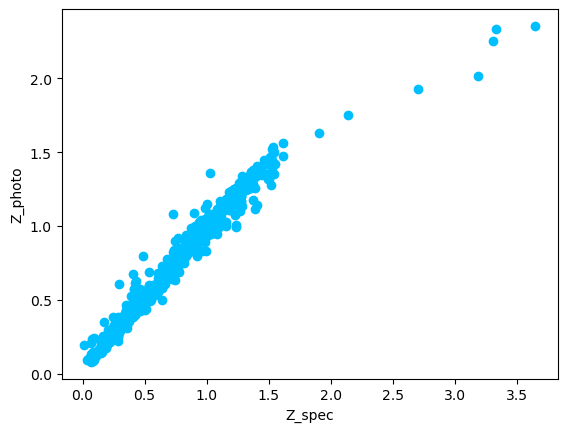

In [20]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_predict, color='deepskyblue')

plt.xlabel('Z_spec')
plt.ylabel('Z_photo');



In [30]:
difference[61], outlier[61]

(0.3136062599718571, 0.19383043)

In [31]:
y_predict.shape, y_test.shape

((1469,), (1469,))

In [56]:
# Compute the outlier fraction 
difference = y_predict - y_test

outlier = 0.15*(1+y_test)

index = []
index.append(np.where(difference > outlier))
index = np.array(index)
#len(index.T)

eta = len(index.T)/len(y_test)
print('Outlier Fraction = ',eta*100,'%')
print('Note that this is much smaller than the outlier fractions reported in the paper.')


Outlier Fraction =  0.4084411164057182 %
Note that this is much smaller than the outlier fractions reported in the paper.


(d) Let's try to optimize hyperparameters `max_features` and `n_estimators`. For `max_features`, try three different values: None, "sqrt", and 2. Compute the test scores of the best model and compare them with what you got in #b. (1 pt)

In [57]:
from sklearn.model_selection import GridSearchCV

# Select hyperparameters to optimize
param_grid = {'max_features': [None, 'sqrt', 2],
             'n_estimators': [100, 300, 500, 700, 900, 1100]}

# Perform a grid search
grid_search = GridSearchCV(RandomForestRegressor(random_state=0), param_grid, cv=5,
                          return_train_score=True, verbose=3)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END max_features=None, n_estimators=100;, score=(train=0.965, test=0.656) total time=   1.0s
[CV 2/5] END max_features=None, n_estimators=100;, score=(train=0.959, test=0.820) total time=   1.0s
[CV 3/5] END max_features=None, n_estimators=100;, score=(train=0.962, test=0.714) total time=   0.9s
[CV 4/5] END max_features=None, n_estimators=100;, score=(train=0.966, test=0.722) total time=   0.9s
[CV 5/5] END max_features=None, n_estimators=100;, score=(train=0.963, test=0.794) total time=   0.9s
[CV 1/5] END max_features=None, n_estimators=300;, score=(train=0.966, test=0.656) total time=   2.8s
[CV 2/5] END max_features=None, n_estimators=300;, score=(train=0.961, test=0.824) total time=   2.8s
[CV 3/5] END max_features=None, n_estimators=300;, score=(train=0.964, test=0.717) total time=   2.8s
[CV 4/5] END max_features=None, n_estimators=300;, score=(train=0.966, test=0.716) total time=   2.8s
[CV 5/5] END max_feat

[CV 2/5] END max_features=2, n_estimators=900;, score=(train=0.960, test=0.806) total time=   3.9s
[CV 3/5] END max_features=2, n_estimators=900;, score=(train=0.963, test=0.731) total time=   3.9s
[CV 4/5] END max_features=2, n_estimators=900;, score=(train=0.964, test=0.685) total time=   3.9s
[CV 5/5] END max_features=2, n_estimators=900;, score=(train=0.961, test=0.770) total time=   3.9s
[CV 1/5] END max_features=2, n_estimators=1100;, score=(train=0.966, test=0.668) total time=   4.8s
[CV 2/5] END max_features=2, n_estimators=1100;, score=(train=0.961, test=0.806) total time=   4.8s
[CV 3/5] END max_features=2, n_estimators=1100;, score=(train=0.964, test=0.733) total time=   4.8s
[CV 4/5] END max_features=2, n_estimators=1100;, score=(train=0.964, test=0.685) total time=   4.7s
[CV 5/5] END max_features=2, n_estimators=1100;, score=(train=0.961, test=0.770) total time=   4.8s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_features': [None, 'sqrt', 2],
                         'n_estimators': [100, 300, 500, 700, 900, 1100]},
             return_train_score=True, verbose=3)

In [58]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best model: {}".format(grid_search.best_estimator_))
print("Test score: {:.2f}".format(grid_search.score(X_test, y_test)))

Best parameters: {'max_features': None, 'n_estimators': 300}
Best model: RandomForestRegressor(max_features=None, n_estimators=300, random_state=0)
Test score: 0.69


In [59]:
# Calculate out-of-bag score for the best model
model = RandomForestRegressor(max_features=None, n_estimators=300, random_state=0, oob_score=True)
model.fit(X, y)
oob = model.oob_score_
print('Out-of-Bag Score = ', oob)

Out-of-Bag Score =  0.7439972671763302


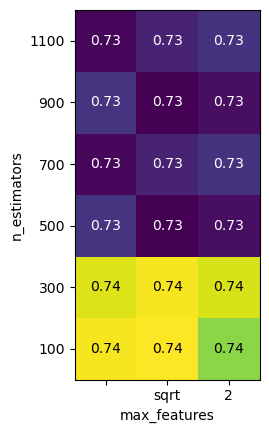

In [60]:
# Visualize hyperparameterization with a heatmap
import pandas as pd
import mglearn 

results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.mean_test_score).reshape(6,3)

mglearn.tools.heatmap(scores, xlabel='max_features', xticklabels=param_grid['max_features'],
                     ylabel='n_estimators', yticklabels=param_grid['n_estimators'], cmap='viridis')



It seems like the max_features might not matter since they all produce the same score.

(e) You might have found that the test scores are not drastically improved. What should we do? Let's try to add u-g, g-r, r-i, i-z, z-y colors and see if it improves the performance. You now have a 11-dimensional dataset. Using this new dataset, make a Random Forest, optimize hyperparameters, and compute the test score of the best model. (1 pt)

In [61]:
# Compute colors
u_g = df_new['u_apercor'] - df_new['g_apercor']
g_r = df_new['g_apercor'] - df_new['r_apercor']
r_i = df_new['r_apercor'] - df_new['i_apercor']
i_z = df_new['i_apercor'] - df_new['z_apercor']
z_y = df_new['z_apercor'] - df_new['y_apercor']


# Gather all the features (including colors) into an array X
X = np.array([df_new['u_apercor'], df_new['g_apercor'], df_new['r_apercor'], df_new['i_apercor'],
            df_new['z_apercor'], df_new['y_apercor'], u_g, g_r, r_i, i_z, z_y]).T
# Put labels into an array y
y = np.array(df_new['zhelio'])

# This is just for plotting
feature_names = ['u', 'g', 'r', 'i', 'z', 'y', 'u-g', 'g-r', 'r-i', 'i-z', 'z-y']

# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


In [62]:
X.shape, y.shape

((5874, 11), (5874,))

In [63]:
# Select hyperparameters to optimize
param_grid = {'max_features': [None, 'sqrt', 2],
             'n_estimators': [100, 300, 500, 700, 900]}

# Perform a grid search
grid_search = GridSearchCV(RandomForestRegressor(random_state=0), param_grid, cv=5,
                          return_train_score=True, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END max_features=None, n_estimators=100;, score=(train=0.971, test=0.781) total time=   1.7s
[CV 2/5] END max_features=None, n_estimators=100;, score=(train=0.970, test=0.858) total time=   1.7s
[CV 3/5] END max_features=None, n_estimators=100;, score=(train=0.974, test=0.731) total time=   1.7s
[CV 4/5] END max_features=None, n_estimators=100;, score=(train=0.976, test=0.746) total time=   1.7s
[CV 5/5] END max_features=None, n_estimators=100;, score=(train=0.972, test=0.872) total time=   1.7s
[CV 1/5] END max_features=None, n_estimators=300;, score=(train=0.971, test=0.783) total time=   5.0s
[CV 2/5] END max_features=None, n_estimators=300;, score=(train=0.970, test=0.859) total time=   5.0s
[CV 3/5] END max_features=None, n_estimators=300;, score=(train=0.975, test=0.737) total time=   5.0s
[CV 4/5] END max_features=None, n_estimators=300;, score=(train=0.975, test=0.743) total time=   4.9s
[CV 5/5] END max_feat

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_features': [None, 'sqrt', 2],
                         'n_estimators': [100, 300, 500, 700, 900]},
             return_train_score=True, verbose=3)

In [64]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best model: {}".format(grid_search.best_estimator_))
print("Test score: {:.2f}".format(grid_search.score(X_test, y_test)))

Best parameters: {'max_features': 'sqrt', 'n_estimators': 900}
Best model: RandomForestRegressor(max_features='sqrt', n_estimators=900, random_state=0)
Test score: 0.76


In [66]:
# Calculate out-of-bag score for the best model
model = RandomForestRegressor(max_features='sqrt', n_estimators=900, random_state=0, oob_score=True)
model.fit(X, y)
oob = model.oob_score_
print('Out-of-Bag Score = ', oob)

Out-of-Bag Score =  0.8034302629408946


(f) With your best model, repeat #c. Make a plot showing photometric redshift vs. spectroscopic redshift, and compute the outlier fraction. Do you find better perfomance? (1 pt)

In [67]:
# Make prediction of testing data
y_predict_new = model.predict(X_test)


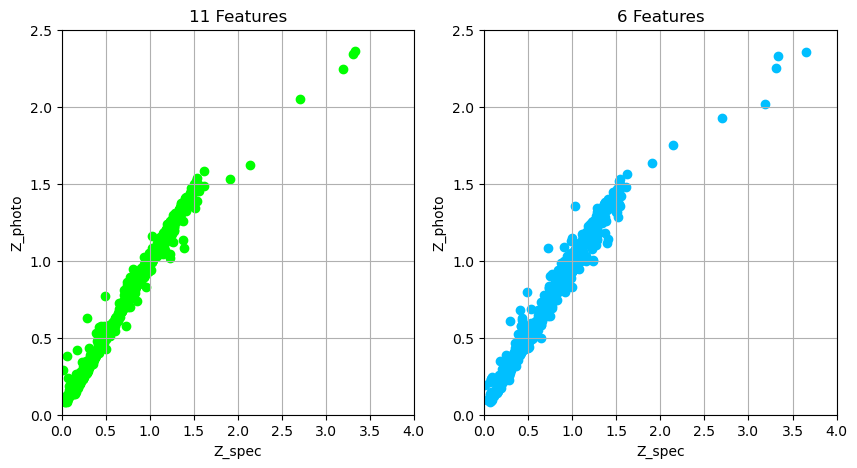

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(y_test, y_predict_new, color='lime')
plt.title('11 Features')
plt.xlabel('Z_spec')
plt.ylabel('Z_photo')
plt.ylim(0,2.5)
plt.xlim(0,2.5)
plt.grid()

plt.subplot(1,2,2)
plt.scatter(y_test, y_predict, color='deepskyblue')
plt.title('6 Features')
plt.xlabel('Z_spec')
plt.ylabel('Z_photo')
plt.ylim(0,3.0)
plt.xlim(0,4.0)
plt.grid();

In [77]:
# Compute the outlier fraction 
difference = y_predict_new - y_test

outlier = 0.15*(1+y_test)

index = []
index.append(np.where(difference > outlier))
index = np.array(index)

eta = len(index.T)/len(y_test)
print('Outlier Fraction = ',eta*100,'%')
print('No change from the smaller dimension.')


Outlier Fraction =  0.4084411164057182 %
No change from the smaller dimension.


(g) Make a plot showing feature importance. Which is more important between colors and magnitudes? Does the feature importance plot support that adding colors helped improve the performance? (1 pt)

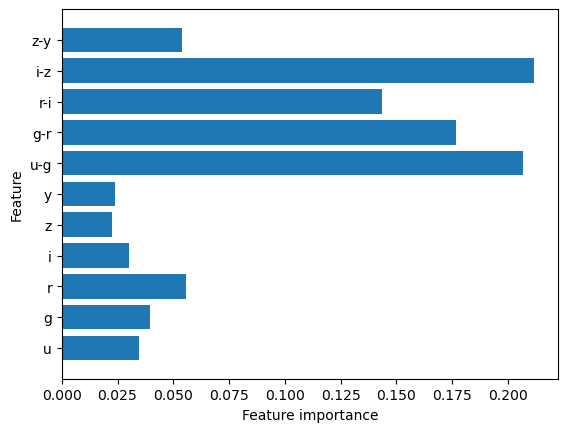

In [78]:
def plot_feature_importances(model):
    n_features = X.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances(model)

**Yes, the feature importance plot supports that adding the color improved performance. Overall, the colors were more important than the magnitudes, with i-z and u-g color being the most important.**

### 2. Photometric redshift estimator using Gradient Boosting (3 pts)


This time, let's use Gradient Boosting to compute photometric redshift. 

(a) Let's use `max_depth=2`. What `n_estimator` should we use? Make a plot showing the validation error vs. n_estimator and find the optimal `n_estimator`. What is your optimal `n_estimator` and what is the test score using the optimal model? (1 pt)

In [84]:
# Gather all the features (including colors) into an array X
X = np.array([df_new['u_apercor'], df_new['g_apercor'], df_new['r_apercor'], df_new['i_apercor'],
            df_new['z_apercor'], df_new['y_apercor'], u_g, g_r, r_i, i_z, z_y]).T
# Put labels into an array y
y = np.array(df_new['zhelio'])

# This is just for plotting
feature_names = ['u', 'g', 'r', 'i', 'z', 'y', 'u-g', 'g-r', 'r-i', 'i-z', 'z-y']

# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [85]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Create model with max_depth=2 and arbitrary n_estimators
model = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
# Fit model to training data
model.fit(X_train, y_train)

#Here, "staged_predict" gives the prediction at each stage.
errors = [mean_squared_error(y_test, y_pred) for y_pred in model.staged_predict(X_test)]
best_n_estimators = np.argmin(errors) + 1

model_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators, random_state=42)
model_best.fit(X_train, y_train)



GradientBoostingRegressor(max_depth=2, n_estimators=109, random_state=42)

Text(0.5, 1.0, 'Validation error')

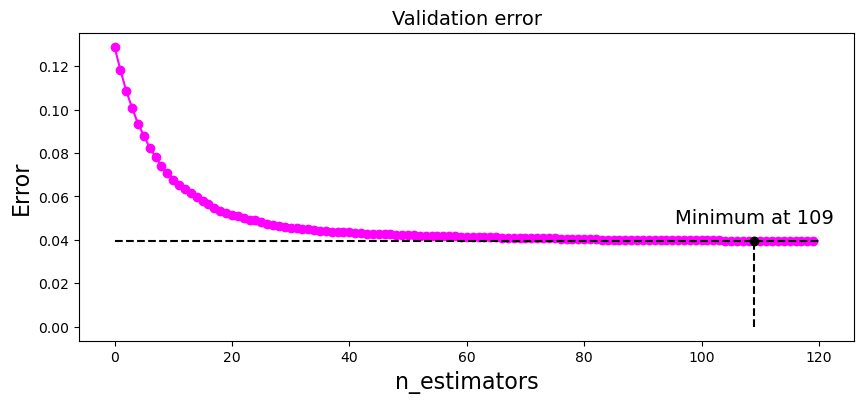

In [119]:
# Make a plot showing the validation error vs. n_estimator
plt.figure(figsize=(10, 4))

min_error = np.min(errors) #Find where the error is minimum 

#plt.subplot(121)
plt.plot(errors, color='fuchsia') #Plot the validation errors calculated about for each n_estimator
plt.scatter(np.arange(120), errors, color='fuchsia') #scatter points
plt.plot([best_n_estimators, best_n_estimators], [0, min_error], "k--") #Vertical line at best n_estimators
plt.plot([0, 120], [min_error, min_error], "k--") #Horizontal line at best n_estimators
plt.plot(best_n_estimators, min_error, "ko") #Point at best n_estimators
plt.text(best_n_estimators, min_error*1.2, "Minimum at "+str(best_n_estimators), ha="center", fontsize=14)
plt.xlabel("n_estimators", fontsize=16)
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)



**Optimal n_estimator = 109.**

In [121]:
# Create the optimal model
model = GradientBoostingRegressor(max_depth=2, n_estimators=109, random_state=42)
# Fit model to training data
model.fit(X_train, y_train)

# Compute the testing score for the optimal model
print('Test score = ',model.score(X_test, y_test))




Test score =  0.7224227701008876


(b) Using the `GradientBoostingRegressor` you built in #a, make predictions for the test dataset. This prediction will be the "photometric redshift". Then, make a scatter plot showing photometric redshift vs. spectroscopic redshift. Your figure should look similar to Figure 5 of Zhou et al. (2019). Also, compute the outlier fraction $\eta$, which is defined as the fraction of objects with $|z_{phot}-z_{spec}| > 0.15*(1+z_{spec})$. (1 pt)

In [130]:
# Make prediction of testing data
y_predict = model.predict(X_test)


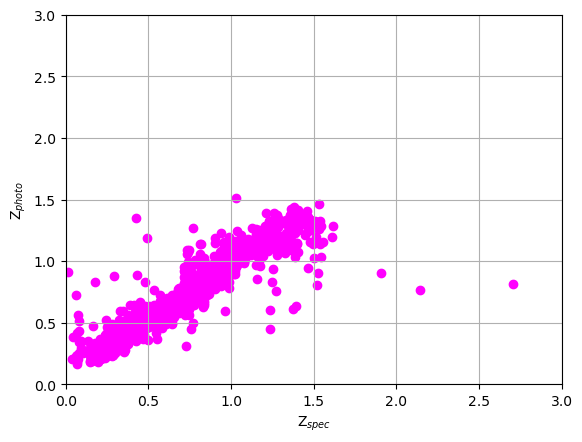

In [141]:
# Plotting
plt.scatter(y_test, y_predict, color='fuchsia')

plt.xlabel('Z$_{spec}$')
plt.ylabel('Z$_{photo}$')
plt.grid()
plt.xlim(0,3.0)
plt.ylim(0,3.0);

In [137]:
# Compute outlier fraction
difference = y_predict - y_test

outlier = 0.15*(1+y_test)

index = []
index.append(np.where(difference > outlier))
index = np.array(index)

eta = len(index.T)/len(y_test)
print('Outlier Fraction = ',eta*100,'%')
print('Outlier fraction is closer to what the paper predicted than my previous models. But still not as close as I would like.')



Outlier Fraction =  2.722940776038121 %
Outlier fraction is closer to what the paper predicted than my previous models. But still not as close as I would like.


(c) Make a movie showing the evolution of photometric redshift vs. spectroscopic redshift as you increase `n_estimator`. See gbr.mp4 on Canvas as an example. Discuss what you see in the movie in the context of boosting. Submit your movie file. (1 pt)

In [147]:
n = 1
n_max = 120

while n < n_max:
    
    # Create the optimal model
    model = GradientBoostingRegressor(max_depth=2, n_estimators=n, random_state=42)
    # Fit model to training data
    model.fit(X_train, y_train)
    
    # Make prediction
    y_predict = model.predict(X_test)
    
    # Plotting
    plt.scatter(y_test, y_predict, color='fuchsia')
    plt.xlabel('Z_spec')
    plt.ylabel('Z_photo')
    plt.xlim(0.0,3.0)
    plt.ylim(0.0,3.0)
    plt.grid()
    plt.title('n_estimators = '+str(n))
    
    # Save figures
    if n < 10:
        plt.savefig('plots/gradBoost_00'+str(n)+'.png')
    if n > 9 and n < 100:
        plt.savefig('plots/gradBoost_0'+str(n)+'.png')
    if n > 99:
        plt.savefig('plots/gradBoost_'+str(n)+'.png')
    
    # Close each figure so my computer doesn't explode
    plt.close()
    
    n = n+1
    
# Note: I made the movie using ffmpeg on the terminal of my local device using the syntax below
#ffmpeg -framerate 10 -pattern_type glob -i '*.png' -c:v libx264 -pix_fmt yuv420p out.mp4

**The predictions generally get better as n_estimators increases. Also, I noticed that Gradient Boosting does not do as good of a job as Random Forest at predicting the higher redshift galaxies (> 1.5). I'm guessing that since the data is less dense in that area the model treats it more like an outlier, and Gradient Boosting can be very sensitive to outliers and noise.**

### Congratulations! You reproduced results presented in yet another journal paper. If you enjoyed the homework and would like to do some additional related analysis, I recommend you have a look at the following papers and references therein. Feel free to read/reproduce them for paper presentation and/or term project.

https://ui.adsabs.harvard.edu/abs/2010ApJ...712..511C/abstract

https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.4847H/abstract

https://ui.adsabs.harvard.edu/abs/2022MNRAS.509.2289L/abstract

https://ui.adsabs.harvard.edu/abs/2022MNRAS.512.1696H/abstract